# Ensemble Model

Comparison of Models for Hand Gesture Recognition Using High-Density sEMG by Group 02

--- STARTING MULTI-SUBJECT TRAINING ---

Processing Subject: P1...
  -> rest: 610 samples
  -> stone: 417 samples
  -> paper: 613 samples
  -> scissors: 557 samples
  -> pointing: 573 samples
  -> rock: 479 samples

Processing Subject: P2...


C:\Users\Britnie Sinthuja\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\Britnie Sinthuja\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


  -> rest: 611 samples
  -> stone: 459 samples
  -> paper: 420 samples


C:\Users\Britnie Sinthuja\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


  -> scissors: 390 samples
  -> pointing: 355 samples
  -> rock: 494 samples

Processing Subject: P3...
  -> rest: 606 samples
  -> stone: 396 samples
  -> paper: 531 samples
  -> scissors: 340 samples
  -> pointing: 360 samples
  -> rock: 353 samples

Total Dataset Size: 8564 samples
Training Ensemble on Combined Data...

=== FINAL COMBINED ACCURACY: 80.50% ===
              precision    recall  f1-score   support

        rest       1.00      1.00      1.00       366
       stone       0.79      0.71      0.75       254
       paper       0.68      0.78      0.73       313
    scissors       0.76      0.69      0.72       257
    pointing       0.80      0.76      0.78       258
        rock       0.77      0.80      0.79       265

    accuracy                           0.81      1713
   macro avg       0.80      0.79      0.79      1713
weighted avg       0.81      0.81      0.81      1713



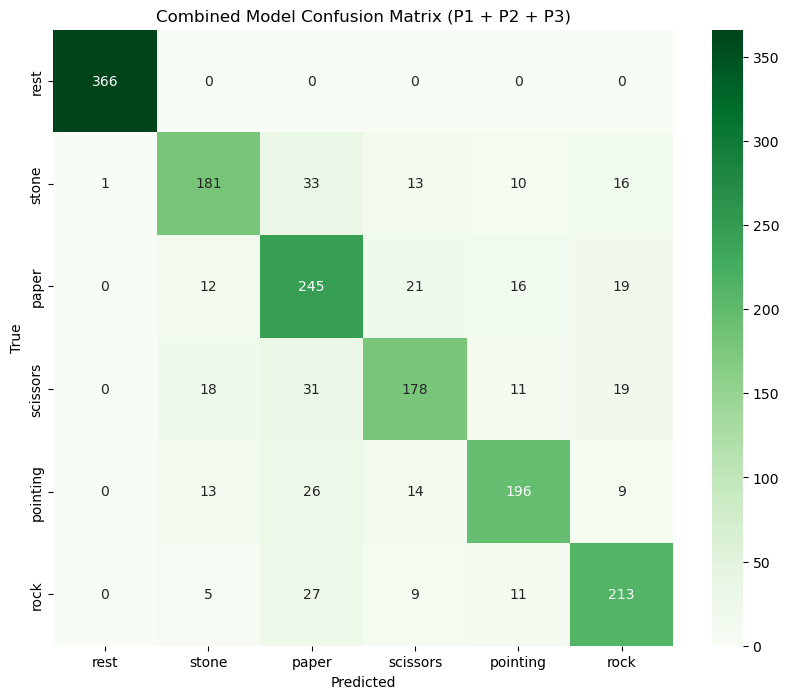

In [1]:
import scipy.io
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- 1. CONFIGURATION ---
SUBJECTS = ['P1', 'P2', 'P3']  
GESTURES = ['rest', 'stone', 'paper', 'scissors', 'pointing', 'rock']
fs = 2048

# Specific cleaning rules for each person
BAD_CHANNELS = {
    'P1': [35],
    'P3': [0, 4, 5, 6, 27],
    'P2': [] 
}
P2_BAD_COMPONENTS = [62, 59, 60, 25, 5, 45, 21, 40, 47] 

# --- 2. PRE-PROCESSING FUNCTIONS ---

def clean_data_router(data, subject):
    """
    Automatic Cleaning Logic:
    - If Subject is P2 -> Run ICA
    - If Subject is P1 or P3 -> Delete Bad Channels
    """
    if subject == 'P2':
        # ICA Strategy
        sos = scipy.signal.butter(4, [20, 450], btype='bandpass', fs=fs, output='sos')
        data_filt = scipy.signal.sosfiltfilt(sos, data, axis=0)
        try:
            ica = FastICA(n_components=64, random_state=42, whiten='unit-variance')
            components = ica.fit_transform(data_filt)
            for idx in P2_BAD_COMPONENTS:
                components[:, idx] = 0
            return ica.inverse_transform(components)
        except:
            return data
    else:
        # Deletion Strategy
        bad_list = BAD_CHANNELS.get(subject, [])
        return np.delete(data, bad_list, axis=1)

def apply_filters(data, fs):
    b, a = scipy.signal.iirnotch(50.0, 30.0, fs)
    data = scipy.signal.filtfilt(b, a, data, axis=0)
    sos = scipy.signal.butter(4, [20, 450], btype='bandpass', fs=fs, output='sos')
    return scipy.signal.sosfiltfilt(sos, data, axis=0)

def extract_features(window):
    features = []
    # Split into 4 zones (works even if channel count changes!)
    zones = np.array_split(window, 4, axis=1)
    for zone in zones:
        features.append(np.mean(np.abs(zone)))       # MAV
        features.append(np.sqrt(np.mean(zone**2)))   # RMS
        zcr = np.sum(np.diff(np.signbit(zone), axis=0)) / (zone.shape[0] * zone.shape[1])
        features.append(zcr)
    return np.array(features)

def load_and_process(gesture_name, subject):
    filepath = f"{subject}/{gesture_name}.otb+.mat"
    if not os.path.exists(filepath): return None
    try:
        mat = scipy.io.loadmat(filepath)
        key = [k for k in mat.keys() if not k.startswith('__') and mat[k].size > 10000][0]
        raw = mat[key]
        if raw.shape[0] < raw.shape[1]: raw = raw.T
        raw = raw[:, :64]
        cleaned = clean_data_router(raw, subject)
        return apply_filters(cleaned, fs)
    except:
        return None

# --- 3. MAIN DATA COLLECTION LOOP ---

X_all = []
y_all = []

print("--- STARTING MULTI-SUBJECT TRAINING ---")

for current_subject in SUBJECTS:
    print(f"\nProcessing Subject: {current_subject}...")
    
    # A. Calculate Threshold specific to this person
    rest_data = load_and_process('rest', current_subject)
    if rest_data is not None:
        rest_energy = np.mean(np.abs(rest_data), axis=1)
        # Using 3*Std to catch weak signals
        subj_threshold = np.mean(rest_energy) + (3 * np.std(rest_energy))
    else:
        subj_threshold = 0.02
        
    # B. Load Files
    window_size = int(0.250 * fs)
    step = int(0.100 * fs)
    
    for label_id, gesture in enumerate(GESTURES):
        data = load_and_process(gesture, current_subject)
        if data is None: 
            # Check for alternate naming (e.g., 'rockmetal' instead of 'rock')
            if gesture == 'rock':
                data = load_and_process('rockmetal', current_subject)
            
            if data is None: continue

        count = 0
        for start in range(0, len(data) - window_size, step):
            window = data[start:start+window_size, :]
            win_energy = np.mean(np.abs(window))
            
            if gesture == 'rest':
                if win_energy < subj_threshold:
                    X_all.append(extract_features(window))
                    y_all.append(label_id)
                    count += 1
            else:
                if win_energy > subj_threshold:
                    X_all.append(extract_features(window))
                    y_all.append(label_id)
                    count += 1
        
        print(f"  -> {gesture}: {count} samples")

# --- 4. TRAIN THE SUPER-MODEL ---

X = np.array(X_all)
y = np.array(y_all)

print(f"\nTotal Dataset Size: {len(X)} samples")

if len(X) == 0:
    print("Error: No data found. Check folder names.")
else:
    # 1. Split (Mixes everyone together)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 2. Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 3. Train Ensemble
    print("Training Ensemble on Combined Data...")
    clf1 = RandomForestClassifier(n_estimators=100, random_state=42)
    clf2 = SVC(kernel='rbf', probability=True, random_state=42)
    clf3 = KNeighborsClassifier(n_neighbors=5)

    voting_model = VotingClassifier(
        estimators=[('rf', clf1), ('svm', clf2), ('knn', clf3)], 
        voting='soft'
    )
    voting_model.fit(X_train_scaled, y_train)

    # 4. Results
    pred = voting_model.predict(X_test_scaled)
    acc = accuracy_score(y_test, pred)
    
    print(f"\n=== FINAL COMBINED ACCURACY: {acc*100:.2f}% ===")

    # Robust Report
    unique_labels = sorted(list(set(y_test)))
    present_names = [GESTURES[i] for i in unique_labels]
    
    print(classification_report(y_test, pred, labels=unique_labels, target_names=present_names))

    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix(y_test, pred, labels=unique_labels), 
                annot=True, fmt='d', cmap='Greens',
                xticklabels=present_names, yticklabels=present_names)
    plt.title('Combined Model Confusion Matrix (P1 + P2 + P3)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# with LOSO

--- STARTING DATA COLLECTION ---

Processing Subject: P1...
  -> rest: 610 samples
  -> stone: 417 samples
  -> paper: 613 samples
  -> scissors: 557 samples
  -> pointing: 573 samples
  -> rock: 479 samples

Processing Subject: P2...


C:\Users\Britnie Sinthuja\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\Britnie Sinthuja\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


  -> rest: 611 samples
  -> stone: 605 samples
  -> paper: 458 samples


C:\Users\Britnie Sinthuja\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


  -> scissors: 396 samples
  -> pointing: 360 samples
  -> rock: 505 samples

Processing Subject: P3...
  -> rest: 606 samples
  -> stone: 396 samples
  -> paper: 531 samples
  -> scissors: 340 samples
  -> pointing: 360 samples
  -> rock: 353 samples

Total Dataset: 8770 samples
Starting Leave-One-Subject-Out (LOSO) Validation...
------------------------------------------------------------
FOLD: Testing on P1
  -> Accuracy: 17.39%
FOLD: Testing on P2
  -> Accuracy: 33.56%
FOLD: Testing on P3
  -> Accuracy: 37.59%
------------------------------------------------------------
AVERAGE ACCURACY: 29.51%
------------------------------------------------------------


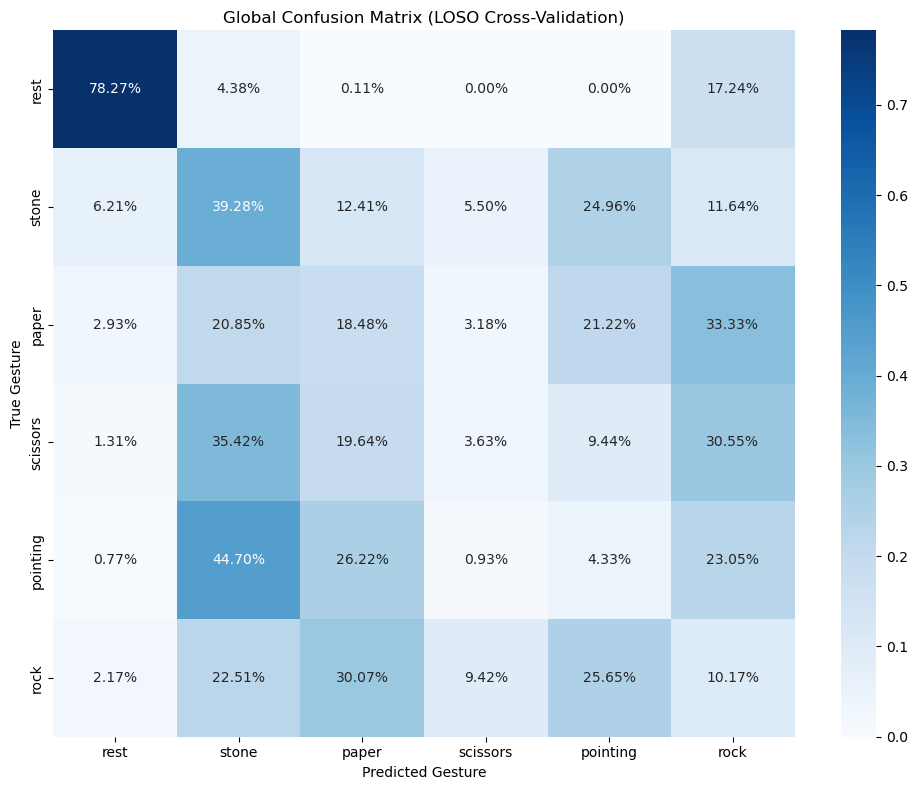


Final Global Classification Report:
              precision    recall  f1-score   support

        rest       0.88      0.78      0.83      1827
       stone       0.24      0.39      0.30      1418
       paper       0.20      0.18      0.19      1602
    scissors       0.15      0.04      0.06      1293
    pointing       0.05      0.04      0.04      1293
        rock       0.07      0.10      0.09      1337

    accuracy                           0.29      8770
   macro avg       0.27      0.26      0.25      8770
weighted avg       0.30      0.29      0.28      8770



In [2]:
import scipy.io
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- 1. CONFIGURATION ---
SUBJECTS = ['P1', 'P2', 'P3'] 
GESTURES = ['rest', 'stone', 'paper', 'scissors', 'pointing', 'rock']
fs = 2048

BAD_CHANNELS = {
    'P1': [35],
    'P3': [0, 4, 5, 6, 27],
    'P2': [] 
}
P2_BAD_COMPONENTS = [62, 59, 60, 25, 5, 45, 21, 40, 47] 

# --- 2. PRE-PROCESSING FUNCTIONS ---

def clean_data_router(data, subject):
    if data.shape[1] > 64:
        data = data[:, :64]
        
    if subject == 'P2':
        sos = scipy.signal.butter(4, [20, 450], btype='bandpass', fs=fs, output='sos')
        data_filt = scipy.signal.sosfiltfilt(sos, data, axis=0)
        try:
            ica = FastICA(n_components=64, random_state=42, whiten='unit-variance', max_iter=1000, tol=0.01)
            components = ica.fit_transform(data_filt)
            for idx in P2_BAD_COMPONENTS:
                components[:, idx] = 0
            return ica.inverse_transform(components)
        except Exception as e:
            print(f"  [!] ICA Failed for P2: {e}")
            return data
    else:
        clean_data = data.copy()
        bad_list = BAD_CHANNELS.get(subject, [])
        if bad_list:
            clean_data[:, bad_list] = 0
        return clean_data

def apply_filters(data, fs):
    b, a = scipy.signal.iirnotch(50.0, 30.0, fs)
    data = scipy.signal.filtfilt(b, a, data, axis=0)
    sos = scipy.signal.butter(4, [20, 450], btype='bandpass', fs=fs, output='sos')
    return scipy.signal.sosfiltfilt(sos, data, axis=0)

def extract_features(window):
    features = []
    zones = np.array_split(window, 4, axis=1)
    for zone in zones:
        features.append(np.mean(np.abs(zone)))       # MAV
        features.append(np.sqrt(np.mean(zone**2)))   # RMS
        zcr = np.sum(np.diff(np.signbit(zone), axis=0)) / (zone.shape[0] * zone.shape[1])
        features.append(zcr)
    return np.array(features)

def load_and_process(gesture_name, subject):
    filepath = f"{subject}/{gesture_name}.otb+.mat"
    if not os.path.exists(filepath): return None
    try:
        mat = scipy.io.loadmat(filepath)
        key = [k for k in mat.keys() if not k.startswith('__') and mat[k].size > 10000][0]
        raw = mat[key]
        if raw.shape[0] < raw.shape[1]: raw = raw.T
        raw = raw[:, :64]
        cleaned = clean_data_router(raw, subject)
        return apply_filters(cleaned, fs)
    except:
        return None

# --- 3. MAIN DATA COLLECTION LOOP ---

X_all = []
y_all = []
groups_all = [] 

print("--- STARTING DATA COLLECTION ---")
subj_map = {name: i for i, name in enumerate(SUBJECTS)}

for current_subject in SUBJECTS:
    print(f"\nProcessing Subject: {current_subject}...")
    rest_data = load_and_process('rest', current_subject)
    if rest_data is not None:
        rest_energy = np.mean(np.abs(rest_data), axis=1)
        subj_threshold = np.mean(rest_energy) + (3 * np.std(rest_energy))
    else:
        subj_threshold = 0.02
        
    window_size = int(0.250 * fs)
    step = int(0.100 * fs)
    
    for label_id, gesture in enumerate(GESTURES):
        data = load_and_process(gesture, current_subject)
        if data is None: 
            if gesture == 'rock':
                data = load_and_process('rockmetal', current_subject)
            if data is None: continue

        count = 0
        for start in range(0, len(data) - window_size, step):
            window = data[start:start+window_size, :]
            win_energy = np.mean(np.abs(window))
            should_add = False
            if gesture == 'rest':
                if win_energy < subj_threshold: should_add = True
            else:
                if win_energy > subj_threshold: should_add = True

            if should_add:
                X_all.append(extract_features(window))
                y_all.append(label_id)
                groups_all.append(subj_map[current_subject])
                count += 1
        print(f"  -> {gesture}: {count} samples")

# --- 4. LEAVE-ONE-SUBJECT-OUT CROSS VALIDATION ---

X = np.array(X_all)
y = np.array(y_all)
groups = np.array(groups_all)

logo = LeaveOneGroupOut()
accuracies = []

# --- NEW: INITIALIZE LISTS FOR GLOBAL RESULTS ---
all_preds = []
all_true = []

print(f"\nTotal Dataset: {len(X)} samples")
print("Starting Leave-One-Subject-Out (LOSO) Validation...")
print("-" * 60)

for train_index, test_index in logo.split(X, y, groups=groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    test_subj_id = groups[test_index][0]
    test_subj_name = SUBJECTS[test_subj_id]
    print(f"FOLD: Testing on {test_subj_name}")
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    clf1 = RandomForestClassifier(n_estimators=100, random_state=42)
    clf2 = SVC(kernel='rbf', probability=True, random_state=42)
    clf3 = KNeighborsClassifier(n_neighbors=5)
    
    voting_model = VotingClassifier(
        estimators=[('rf', clf1), ('svm', clf2), ('knn', clf3)], 
        voting='soft'
    )
    
    voting_model.fit(X_train_scaled, y_train)
    pred = voting_model.predict(X_test_scaled)
    
    # --- NEW: STORE PREDICTIONS FOR CONFUSION MATRIX ---
    all_preds.extend(pred)
    all_true.extend(y_test)
    
    acc = accuracy_score(y_test, pred)
    accuracies.append(acc)
    print(f"  -> Accuracy: {acc*100:.2f}%")

print("-" * 60)
print(f"AVERAGE ACCURACY: {np.mean(accuracies)*100:.2f}%")
print("-" * 60)

# --- 5. FINAL CONFUSION MATRIX PLOT ---

plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_true, all_preds)

# Normalize the matrix to show percentages
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=GESTURES, yticklabels=GESTURES)

plt.title('Global Confusion Matrix (LOSO Cross-Validation)')
plt.xlabel('Predicted Gesture')
plt.ylabel('True Gesture')
plt.tight_layout()
plt.show()

print("\nFinal Global Classification Report:")
print(classification_report(all_true, all_preds, target_names=GESTURES))